In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import sys
sys.path.append("./../code/")
from piCurve import *
from matplotlib import cm
from gwBackground import *
from makeDelayedRateData import *
from scipy.special import gammainc
from geometry import *
import population_parameters

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
def read_output(filepath):
    
    # Read hdf file
    hfile = h5py.File(filepath,'r')
    
    # Get joint 2D posteriors
    resultsDict = {k:v[()] for k,v in hfile['result'].items()}
    
    return resultsDict

def get_max_likelihood_params(resultDict):
    
    dc_argmax,z_argmax = np.unravel_index(np.argmax(resultDict['probabilities']),resultDict['probabilities'].shape)
    kappa_dc_max = resultDict['kappa_dcs_2D'][dc_argmax]
    kappa_z_max = resultDict['kappa_zs_2D'][z_argmax]
    
    return kappa_dc_max,kappa_z_max

In [3]:
# Input data
f_H1V1_O3,C_H1V1_O3,sigma_H1V1_O3 = np.loadtxt('../input/H1V1_O3.dat',unpack=True,skiprows=1)

# Inference results
full = read_output('./../data/fixed_rate_delayedSFR.hdf')

In [4]:
full_kappa_dc_max,full_kappa_z_max = get_max_likelihood_params(full)

In [5]:
# First prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model a metallicity-weighted and time-delayed Madau+Dickinson SFR
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_delayed = weightedFormationRates.dot(dpdt)
dRdV_delayed /= dRdV_delayed[0]

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/gwBackground.py:352: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


In [6]:
# To correctly calculate the cumulative SNR, load ORFs computed in stochastic.m
# to identically match the ORFs used in normalizing the sigma(f) spectrum
matlab_orf_freqs,matlab_orf_H1L1,matlab_orf_H1V1,matlab_orf_L1V1 = np.loadtxt('../input/matlab_orfs.dat',unpack=True)
freqs = matlab_orf_freqs[matlab_orf_freqs<=1726]
matlab_orf_H1V1 = matlab_orf_H1V1[matlab_orf_freqs<=1726]

# For comparison, also compute ORFs in python using our baseline object
H1V1 = Baseline(Detector.H1(),Detector.V1())
H1V1_gammaI,H1V1_gammaV = H1V1.stokes_overlap_reduction_functions(freqs)

In [7]:
# Compute energy density spectra
full_OmgI,full_OmgV = omg.eval(R0,dRdV_delayed,freqs,full_kappa_dc_max,full_kappa_z_max)

# Compute expected signal model using both ORFs
HV_model = np.array(full_OmgI + (H1V1_gammaV/matlab_orf_H1V1)*full_OmgV)
HV_model_badORF = np.array(full_OmgI + (H1V1_gammaV/H1V1_gammaI)*full_OmgV)

In [8]:
def get_cumulative_snr(Cs,sigmas,model):
    
    Cs[np.isinf(sigmas)] = 0
    signal_inner_model = np.cumsum(Cs*model/sigmas**2)
    model_inner_model = np.cumsum(model**2/sigmas**2)
    
    return signal_inner_model/np.sqrt(model_inner_model)

In [9]:
# Hanford-Virgo SNRs
cumulative_HV = get_cumulative_snr(C_H1V1_O3,sigma_H1V1_O3,HV_model)
badORF_cumulative_HV = get_cumulative_snr(C_H1V1_O3,sigma_H1V1_O3,HV_model_badORF)

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_57884/4118186826.py:7: RuntimeWarning: invalid value encountered in divide
  return signal_inner_model/np.sqrt(model_inner_model)


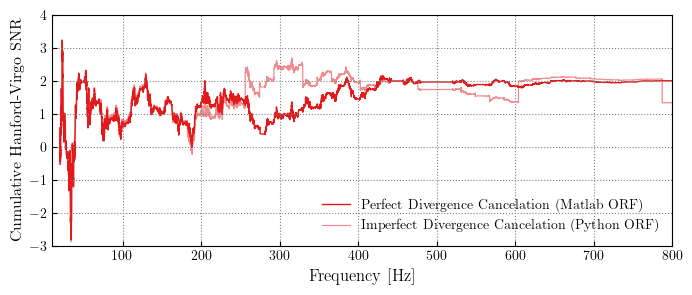

In [10]:
fig,ax = plt.subplots(figsize=(8,3))
ax.set_rasterization_zorder(2)

ax.plot(freqs,cumulative_HV,color=red,lw=1,alpha=1,label='Perfect Divergence Cancelation (Matlab ORF)',zorder=0)
ax.plot(freqs,badORF_cumulative_HV,color=red,lw=0.9,alpha=0.5,label='Imperfect Divergence Cancelation (Python ORF)',zorder=0)

ax.legend(loc='lower right',fontsize=10)

ax.set_xlim(10,800)
ax.set_ylim(-3,4)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cumulative Hanford-Virgo SNR',fontsize=11.5)

plt.savefig('figure_18.pdf',bbox_inches='tight',dpi=200)